# Converting the VIPER dataset to a KITTI Structure
We want to extract as much meaningful images as possible from the VIPER dataset and convert them to the KITTI dataset structure.

### Structure
The VIPER dataset is split into training, validation, and test set. 
Each subset is further divided into a number of video sequences. Each video
sequence was recorded in 1 of 5 environmental conditions (day, sunset, rain, 
night, snow). The frame rate of each sequence is approximately 15 fps.

### Input images (img)
Each image was recorded in 1080p (1920x1080 pixels). Due to the large number of 
frames, we provide the images in lossy JPG and lossless PNG format. 

### 2D/3D Bounding boxes (bb)
We provide bounding boxes in 2D (on the image plane) and in 3D 
(in camera coordinate frame) for a subset of the semantic classes. The 
annotations are stored as one CSV file per frame. Each row in one of the files
corresponds to a single object instance. The format for the columns is
classID, instanceID, 2D bounding box (4 values), 3D bounding box in model 
coordinate frame (6 values), matrix to transform 3D bounding box into camera 
coordinate frame (16 values).
An example for visualizing the bounding boxes for one frame is given in 
'drawBoundingBox.m'.



## Import Modules

In [114]:
from kittipy import display_im                   # https://github.com/LucasVandroux/KittiPy/releases/tag/v1.0
from imageio import imread as imread, imwrite    # Read and write images
from skimage.transform import resize             # Resize images
import os                                        # Use to list all the files in a folder
import os.path as path                           # System paths management
import json                                      # Save intermediary files

## Global Variables

In [131]:
# Weather conditions to extract
list_weather = ['day', 'sunset', 'night', 'rain', 'snow']    # Default: ['day', 'sunset', 'night', 'rain', 'snow']

# Classes information
path_classes = '/Users/lucas/Documents/Master Thesis/gta_dataset/readme/classes.csv'  # https://storage.googleapis.com/playing-for-benchmarks-download/readme.zip

# Training folder
t_path_weather = '/Volumes/BLUE_TRANS/gta_dataset/train/weather.txt'   # https://drive.google.com/uc?id=1fJTx6-bfKYQs1CQD1yh7RsTIjhR3n0y0&export=download
t_path_labels = '/Volumes/BLUE_TRANS/gta_dataset/train/bb'             # https://drive.google.com/uc?id=1r9xZmfAT75geV2ieotND4U7OMbBkp2OQ&export=download

# Validation folder (Optional: but can be used to get even more images)
use_val_sets = True                                           
v_path_weather = '/Volumes/BLUE_TRANS/gta_dataset/val/weather.txt'     # https://drive.google.com/uc?id=1IDohh9gmdKKHvlixzsxKM_HAMKcl78Kg&export=download
v_path_labels = '/Volumes/BLUE_TRANS/gta_dataset/val/bb'               # https://drive.google.com/uc?id=1OSL9TIJNr-HNeNuTvxeejsrxuu__anOM&export=download

### Correspondances between VIPER classes and KITTI classes

In [127]:
# Correspondance between KITTI classes and GTA classses
classes_corres = {
    'Car': ['car'],
    'Van': ['van'],
    'Truck': ['truck'],
    'Pedestrian': ['person'],
    'Person_sitting': [],
    'Cyclist': ['bicycle'],
    'Tram': ['train'],
    'Misc': ['motorcycle', 'bus', 'trailer', 'animal'],
    'DontCare': ['ambiguous'],
    'Ignore': ['unlabeled', 'sky', 'road', 'sidewalk', 'railtrack',\
               'terrain', 'tree', 'vegetation', 'building',\
               'infrastructure', 'fence', 'billboard', 'trafficlight',\
               'trafficsign', 'mobilebarrier', 'firehydrant', 'chair',\
               'trash', 'trashcan', 'plane', 'boat']
}

# Inverse classes_corres
gta2kitti = {}
for k, v_list in classes_corres.items():
    if not k == 'Ignore': # remove 'Ignore' classes
        for v in v_list:
            gta2kitti[v] = k

print(json.dumps(gta2kitti, indent=2))

{
  "trailer": "Misc",
  "train": "Tram",
  "bus": "Misc",
  "bicycle": "Cyclist",
  "ambiguous": "DontCare",
  "car": "Car",
  "person": "Pedestrian",
  "van": "Van",
  "animal": "Misc",
  "motorcycle": "Misc",
  "truck": "Truck"
}


## Function to Import Sets' Name Based on Selected Weather Conditions

In [120]:
def import_sets_name(path_weather_file, list_weather):
    # Initialized dict to store weather information per folder
    weather_dict = {w: [] for w in list_weather}

    # File Organization [id_set, weather]:
    with open(path_weather_file) as f:
        for line in f:
            # Parse line
            line_parsed = line.strip().split(',')

            # Fill the dictionary with the values
            weather_dict[line_parsed[1]].append(line_parsed[0])
    
    return weather_dict         

## Function to Import Classes ID

In [132]:
def import_classes_id(path_classes_file, gta2kitti, classes_corres):
    # Extract correspondance between id and classname in the classes.csv
    id2class = {}
    
    with open(path_classes_file) as f:
        for line in f:
            # Parse line
            line_parsed = line.strip().split(',')

            if not line_parsed[0] == 'id': # Ignore header
                id2class[line_parsed[0]]= line_parsed[1]

    # Create dictionnary to extract future classes from GTA dataset
    classes_dict = {k:{'kitti': gta2kitti[v], 'gta': v} for k, v in id2class.items() if not v in classes_corres['Ignore']}        
    
    return classes_dict

In [137]:
# Check if using validation sets
print('-> Use Validation Sets: ' + str(use_val_sets))

# --- WEATHER ---
# Import sets according to weather conditions
weather_dict = {}
weather_dict['train'] = import_sets_name(t_path_weather, list_weather)
if use_val_sets:
    weather_dict['val'] = import_sets_name(v_path_weather, list_weather)

# Print repartition of the weather conditions
print('-> Count Sets per Weather:')
count_sets_per_weather = {w: 0 for w in ['day', 'sunset', 'night', 'rain', 'snow']}
for _, rep_weather in weather_dict.items():
    for weather, list_sets in rep_weather.items():
        count_sets_per_weather[weather] += len(list_sets)
print(count_sets_per_weather)

# --- CLASSES ---
# Import Classes ID
classes_dict = import_classes_id(path_classes, gta2kitti, classes_corres)

# Print classes correspondance
print('-> Classes Correspondance:')
for class_id, class_info in classes_dict.items():
    print(' - ' + class_info['gta'] + '[id:' + class_id + '] = ' + class_info['kitti'])



-> Use Validation Sets: True
-> Count Sets per Weather:
{'sunset': 27, 'rain': 15, 'day': 31, 'night': 31, 'snow': 20}
-> Classes Correspondance:
 - van[id:25] = Van
 - animal[id:21] = Misc
 - motorcycle[id:23] = Misc
 - bicycle[id:22] = Cyclist
 - ambiguous[id:1] = DontCare
 - train[id:29] = Tram
 - person[id:20] = Pedestrian
 - trailer[id:28] = Misc
 - bus[id:26] = Misc
 - truck[id:27] = Truck
 - car[id:24] = Car


From KITTI:
 ↳ At least one object per image (Car, Cyclist or Pedestrian in  
 Easy: Min. bounding box height: 40 Px, Max. occlusion level: Fully visible, Max. truncation: 15 %
 Moderate: Min. bounding box height: 25 Px, Max. occlusion level: Partly occluded, Max. truncation: 30 %
 Hard: Min. bounding box height: 25 Px, Max. occlusion level: Difficult to see, Max. truncation: 50 %
 
 Correspondance KITTI classes with GTA_Dataset:
 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'
 In KITII buses and motorcycles and trailer are considered as MISC (see 00098.png) --> try to avoid them in the selection of the images
 
 Check if train in GTA can be seen as tram in KITTI or discard.
 
 DontCare are ambiguous or too small labels
 

### Process to convert and select the labels:
1. Select only the labels we are interested in
2. convert bboxes coordinates to new ones
3. only keep the ones meeting the requirements in size 
4. Keep small cars and other classes in DontCare for training
Size image KITTI: 1242 × 375
Size original GTA dataset: 1920 x 1080

Go to folder, with correct weather, start at the 4th image (to have the three before ready)
take the next picture 15 frames later and analyse it if not enough object of interested get to nextt one until find one.


    


In [55]:
def extract_labels(path_labels_file, classes_dict):
    img_dim1 = [1920, 1080]   # size original image
    img_dim2 = [1242, 699]    # size image once cropped
    cy_min = 84               # Crop y min
    kitti_dimy = 375          # y dim of kitti images
    
    min_obj_height = 25
    max_ratio = 1.5
    min_ratio = 0.65
    
    labels_list = []
    contains_oi = False # Contains at least one Object of interest
    
    # File Organization [id_set, weather]:
    with open(path_labels_file) as f:
        for line in f:
            # Parse line
            line_p = line.strip().split(',')

            class_id = line_p[0]
            x_min = int(int(line_p[2]) * img_dim2[0] / img_dim1[0])
            y_min = max(0, int(int(line_p[3]) * img_dim2[1] / img_dim1[1]) - cy_min)
            x_max = int(int(line_p[4]) * img_dim2[0] / img_dim1[0])
            y_max = min(kitti_dimy, int(int(line_p[5]) * img_dim2[1] / img_dim1[1]) - cy_min)
    
            if class_id in classes_dict.keys() and y_min <= kitti_dimy:
                height = y_max - y_min
                width = x_max - x_min
                ratio = height / (width + 0.00000001)
                
                class_name = classes_dict[class_id]['kitti']
                
                if class_name == 'Pedestrian' and ratio < min_ratio:
                    # Pedestrian have too weird ratio (probably drivers)
                    class_name = 'DontCare'
                
                elif ratio > max_ratio and not class_name in ['Pedestrian', 'Cyclist']:
                    # Object are too much occluded
                    class_name = 'DontCare'
                    
                elif height < min_obj_height:
                    # Keep the object but set is as DontCare
                    class_name = 'DontCare'
                
                if class_name in ['Pedestrian', 'Cyclist', 'Car']:
                    contains_oi = True
                    
                labels_list.append(
                    {'type': class_name, 'bbox':{
                        'x_min': x_min,
                        'y_min': y_min,
                        'x_max': x_max,
                        'y_max': y_max}
                    }
                )
            
    return labels_list, contains_oi

(375, 1242, 3)


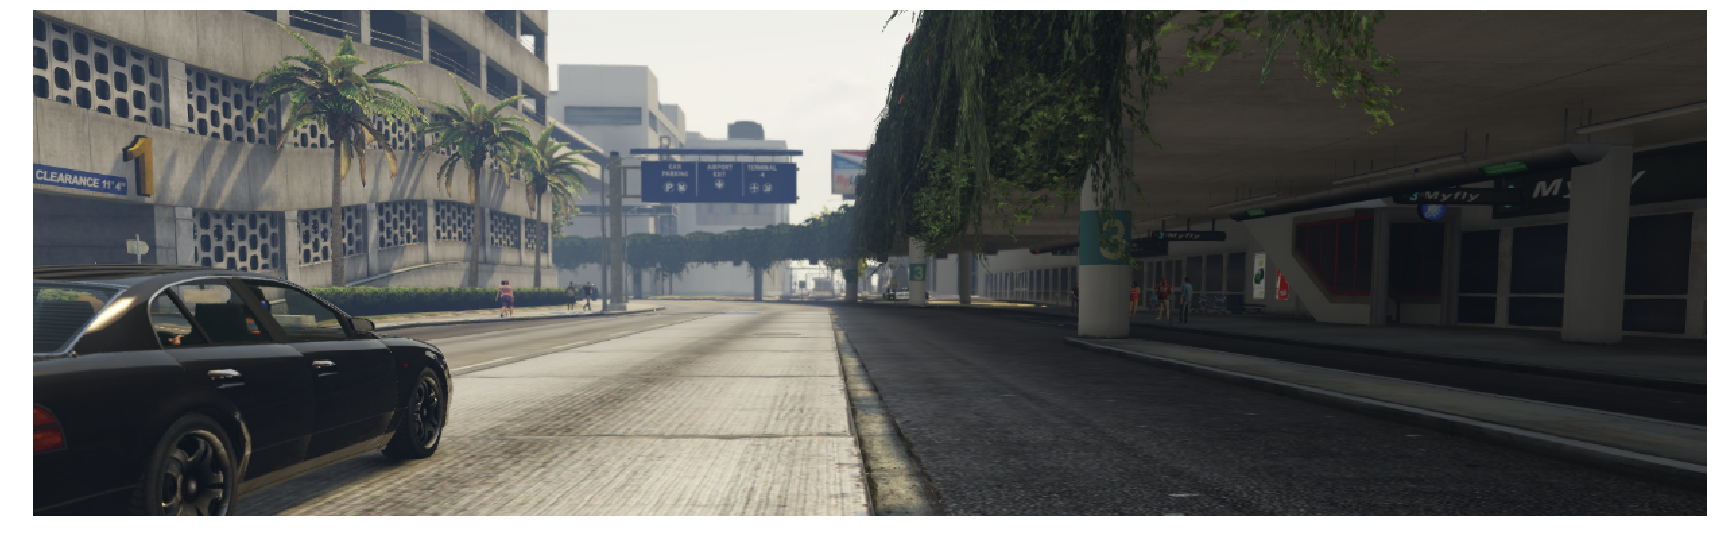

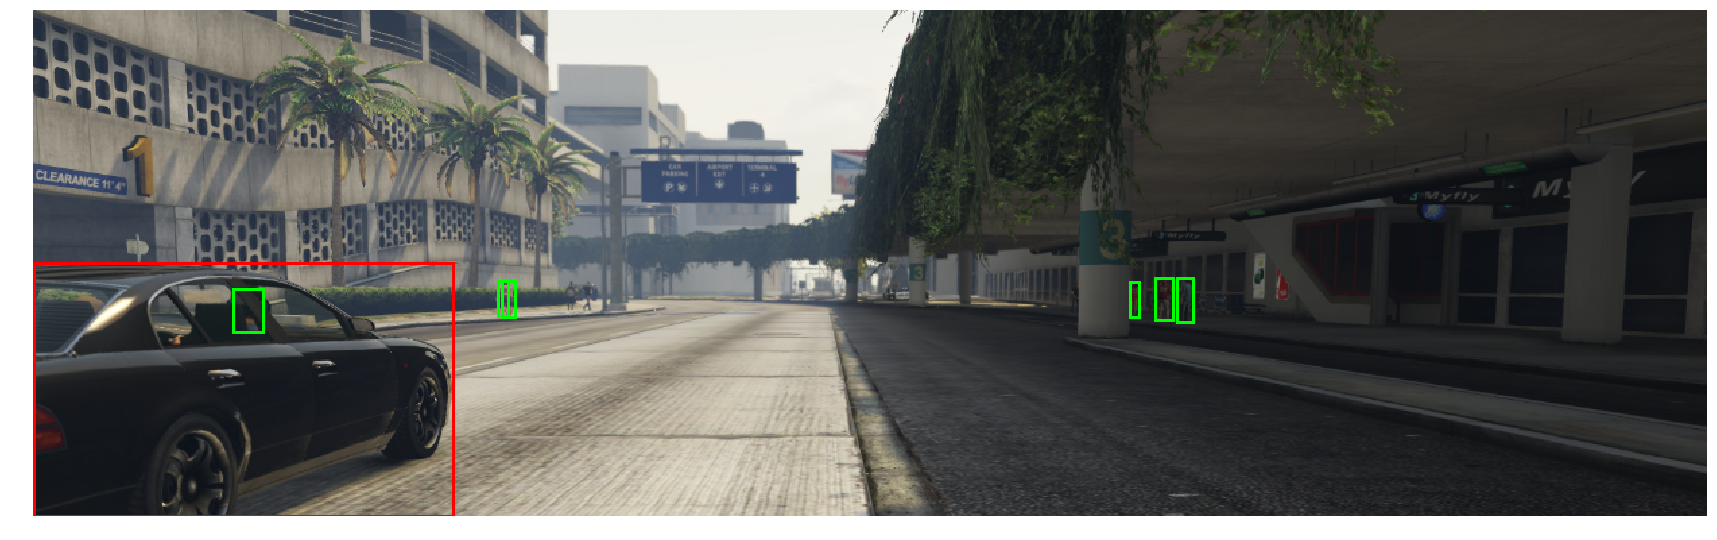

----------------------------------------------------------------------
|type            |  x_min     |  x_max     |  y_min     |  y_max     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Car             |  0         |  311       |  187       |  375       |
----------------------------------------------------------------------
|Pedestrian      |  848       |  860       |  198       |  231       |
----------------------------------------------------------------------
|Pedestrian      |  832       |  845       |  198       |  229       |
----------------------------------------------------------------------
|Pedestrian      |  347       |  357       |  200       |  227       |
----------------------------------------------------------------------
|Pedestrian      |  813       |  820       |  201       |  227       |
----------------------------------------------------------------------
|Pedes

In [97]:
from kittipy import display_im
from imageio import imread as imread
from skimage.transform import resize

%matplotlib inline

img_dim = (699,1242)

folder_name = '002'
img = '00049'

im_path = '/Volumes/BLUE_TRANS/gta_dataset/train/img/' + folder_name + '/' + folder_name + '_' + img + '.png'
lb_path = '/Volumes/BLUE_TRANS/gta_dataset/train/bb/' + folder_name + '/' + folder_name + '_' + img + '.csv'

# im_path = '/Users/lucas/Desktop/044_00034.png'
# lb_path = '/Users/lucas/Desktop/044_00034.csv'

# TYPES_TO_DISPLAY = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
TYPES_TO_DISPLAY = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

im_ = imread(im_path)
im = resize(im_, img_dim, mode='reflect')[84:459, :, :]

labels, _ = extract_labels(lb_path, classes_dict)

print(im.shape)

display_im(im)
display_im(im, labels, types_to_display=TYPES_TO_DISPLAY, display_info=True, display_center_boxes = False)

012_00004


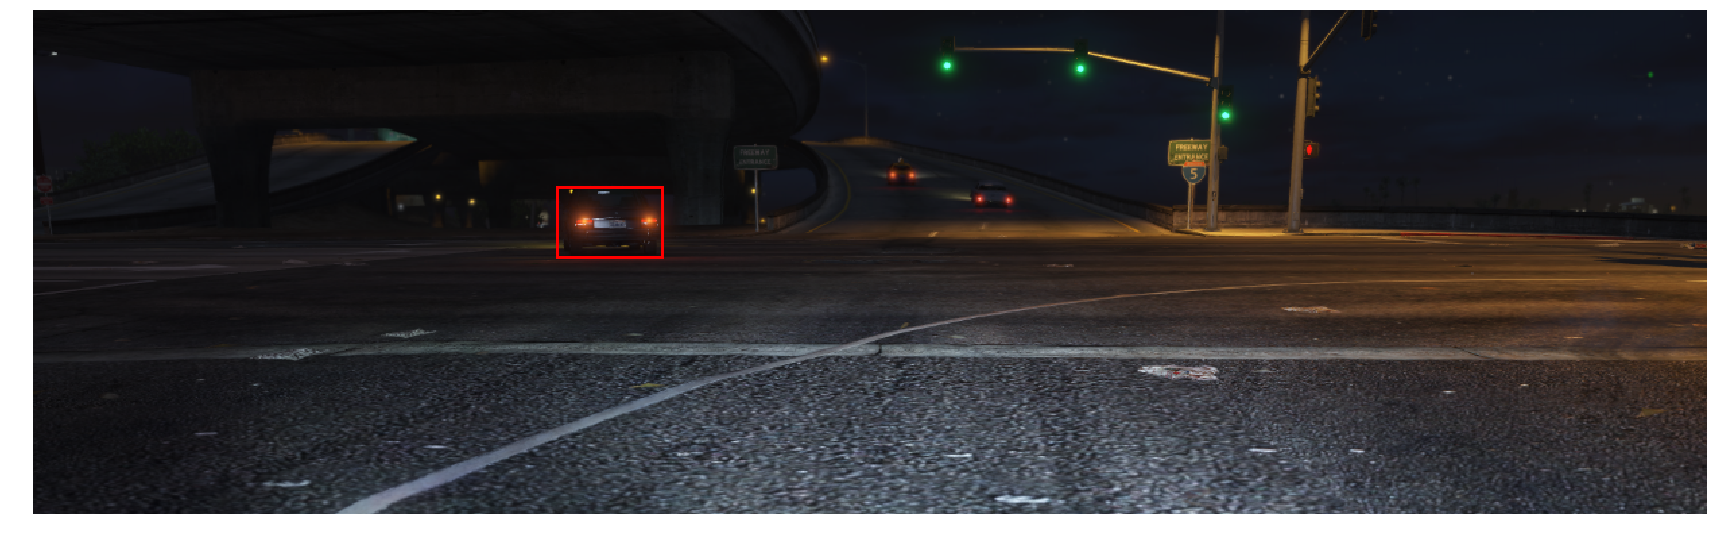

012_00019


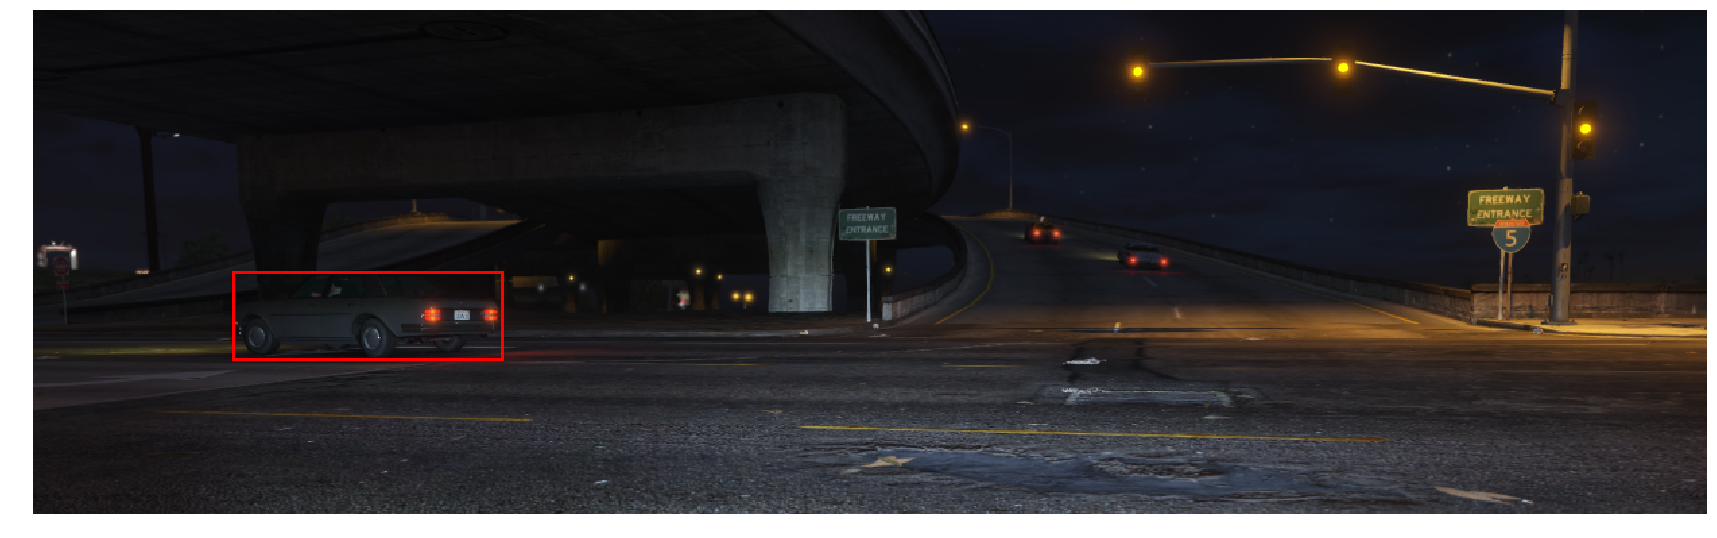

012_00034


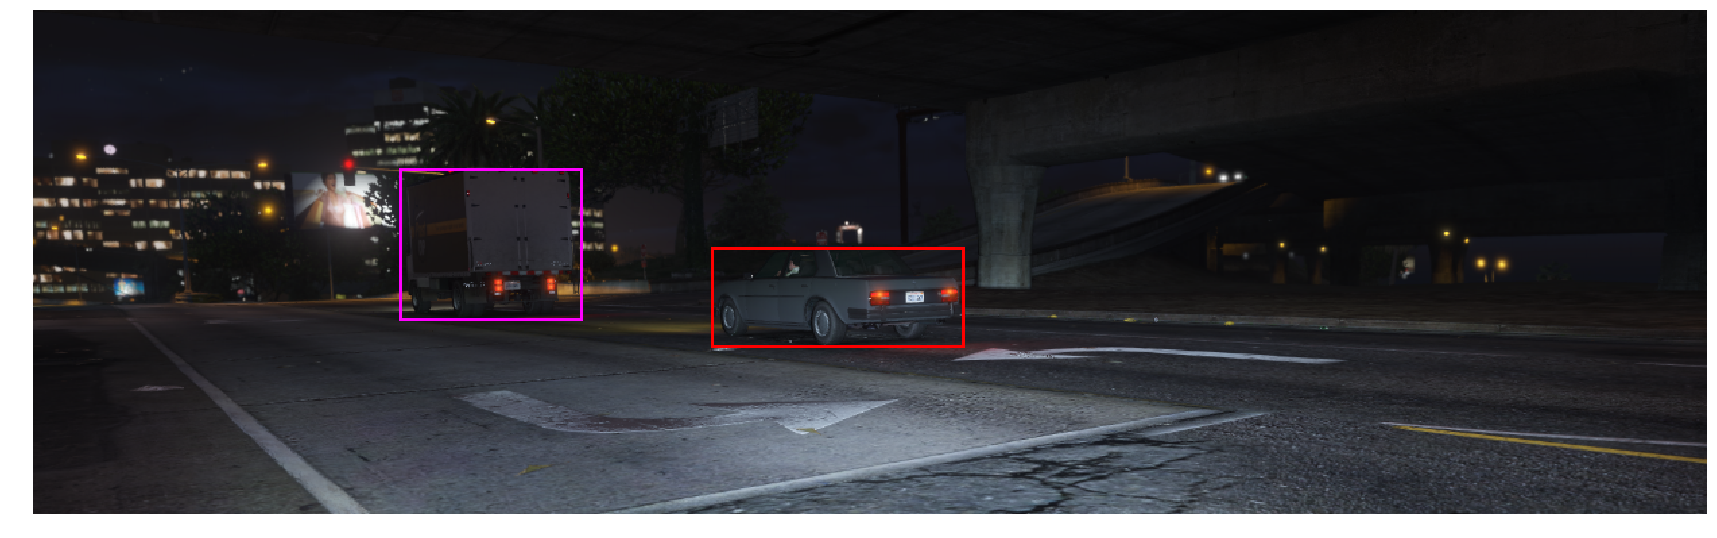

012_00049


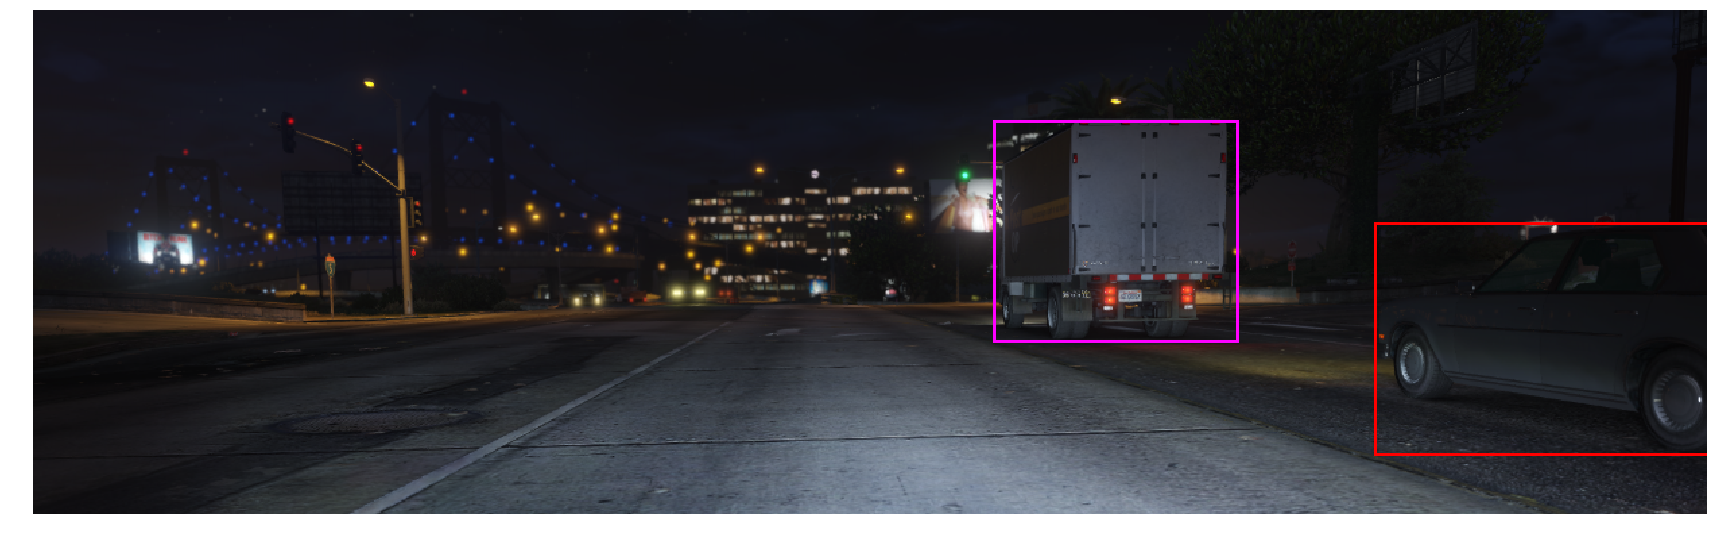

012_00064


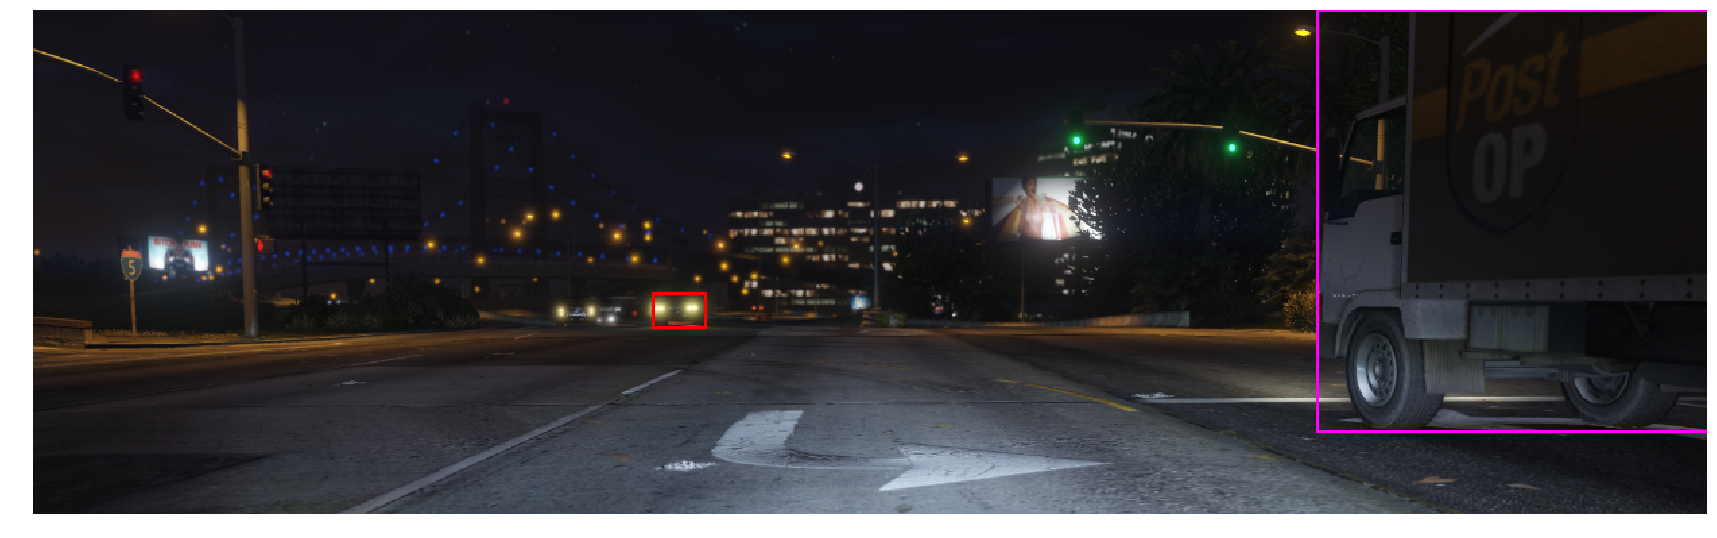

012_00079


OSError: No such file: '/Volumes/BLUE_TRANS/gta_dataset/train/img/012/012_00079.png'

In [95]:
from kittipy import display_im
from imageio import imread as imread, imwrite
from skimage.transform import resize

%matplotlib inline

img_dim = (699,1242)
#TYPES_TO_DISPLAY = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
TYPES_TO_DISPLAY = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

folder_name = '012'
list_img = ['00004', '00019', '00034', '00049', '00064', '00079', '00094', '00109', '00124', '00139']
#list_img = ['00004', '00008', '00012', '00016', '00020', '00024', '00028', '00032', '00036', '00040']

for img in list_img:
    im_path = '/Volumes/BLUE_TRANS/gta_dataset/train/img/' + folder_name + '/' + folder_name + '_' + img + '.png'
    lb_path = '/Volumes/BLUE_TRANS/gta_dataset/train/bb/' + folder_name + '/' + folder_name + '_' + img + '.csv'
    
    print(folder_name + '_' + img)
    
    im_ = imread(im_path)
    im = resize(im_, img_dim, mode='reflect')[85:459, :, :]

    labels, _ = extract_labels(lb_path, classes_dict)

    display_im(im, labels, types_to_display=TYPES_TO_DISPLAY, display_info=False, display_center_boxes = False)

In [87]:
import os
import os.path as path

def extract_labels_from_folder(lbl_folder_path, classes_dict, interval):
    list_img_labels = []
    
    print('Analysing \'' + lbl_folder_path + '\':')
    list_lbl = [lbl_name for lbl_name in os.listdir(lbl_folder_path) if lbl_name.lower().endswith('.csv') and not lbl_name.startswith('.')]
    list_lbl.sort()
    num_lbl = len(list_lbl)
    print(' \'-> ' + str(num_lbl) + ' .csv found')
    
    idx = 3 # Keep 3 images before to extract them later
    
    while idx < num_lbl:
        lb_path = path.join(lbl_folder_path, list_lbl[idx])
        labels, contains_oi = extract_labels(lb_path, classes_dict) 
        
        if contains_oi:
            img_name =  list_lbl[idx][:-4] + '.png'
            list_img_labels.append({'filename': img_name, 'bboxes': labels})
            idx += interval
        
        else:
            idx += 1
    
    return list_img_labels

In [66]:
list_img_labels = extract_labels_from_folder('/Volumes/BLUE_TRANS/gta_dataset/train/bb/007', classes_dict, 8)
list_img_labels

Analysing '/Volumes/BLUE_TRANS/gta_dataset/train/bb/007':
 '-> 2736 .csv found
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00004.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00012.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00020.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00028.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00036.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00044.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00052.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00060.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00068.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00076.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00084.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00092.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00100.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00108.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00116.csv
/Volumes/BLUE_TRANS/gta_dataset/trai

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00664.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00665.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00666.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00667.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00668.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00669.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00670.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00671.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00672.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00673.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00674.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00675.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00676.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00677.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00678.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00679.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00680.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00896.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00897.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00898.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00899.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00900.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00901.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00902.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00903.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00904.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00905.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00906.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00907.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00908.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00909.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00910.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00911.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_00912.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01092.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01093.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01094.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01095.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01096.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01097.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01098.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01099.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01100.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01101.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01109.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01117.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01125.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01133.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01134.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01135.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01136.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01279.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01280.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01281.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01282.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01283.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01284.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01285.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01286.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01287.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01288.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01289.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01290.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01291.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01292.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01293.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01294.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_01295.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02018.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02019.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02020.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02021.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02022.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02023.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02024.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02025.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02026.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02027.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02028.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02029.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02030.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02031.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02032.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02033.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02034.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02166.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02167.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02168.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02169.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02170.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02171.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02172.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02173.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02174.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02175.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02183.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02191.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02199.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02200.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02201.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02202.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02203.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02357.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02358.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02359.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02360.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02361.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02362.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02363.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02364.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02365.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02366.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02367.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02368.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02369.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02370.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02371.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02372.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02373.c

/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02572.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02573.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02574.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02575.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02576.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02577.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02578.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02579.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02580.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02581.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02582.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02583.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02584.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02585.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02593.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02601.csv
/Volumes/BLUE_TRANS/gta_dataset/train/bb/007/007_02609.c

[{'bboxes': [{'bbox': {'x_max': 183, 'x_min': 0, 'y_max': 242, 'y_min': 158},
    'type': 'Car'},
   {'bbox': {'x_max': 307, 'x_min': 217, 'y_max': 202, 'y_min': 166},
    'type': 'Car'},
   {'bbox': {'x_max': 653, 'x_min': 626, 'y_max': 183, 'y_min': 163},
    'type': 'DontCare'},
   {'bbox': {'x_max': 599, 'x_min': 571, 'y_max': 182, 'y_min': 163},
    'type': 'DontCare'},
   {'bbox': {'x_max': 593, 'x_min': 566, 'y_max': 180, 'y_min': 159},
    'type': 'DontCare'},
   {'bbox': {'x_max': 628, 'x_min': 610, 'y_max': 180, 'y_min': 165},
    'type': 'DontCare'},
   {'bbox': {'x_max': 625, 'x_min': 606, 'y_max': 178, 'y_min': 167},
    'type': 'DontCare'},
   {'bbox': {'x_max': 617, 'x_min': 600, 'y_max': 177, 'y_min': 164},
    'type': 'DontCare'},
   {'bbox': {'x_max': 549, 'x_min': 533, 'y_max': 176, 'y_min': 165},
    'type': 'DontCare'},
   {'bbox': {'x_max': 706, 'x_min': 694, 'y_max': 172, 'y_min': 164},
    'type': 'DontCare'},
   {'bbox': {'x_max': 529, 'x_min': 518, 'y_max': 17

In [71]:
[lbl for lbl in list_img_labels[1]['bboxes'] if lbl['type'] in ['Pedestrian', 'Car', 'Cyclist']]

[{'bbox': {'x_max': 666, 'x_min': 633, 'y_max': 208, 'y_min': 183},
  'type': 'Car'},
 {'bbox': {'x_max': 68, 'x_min': 52, 'y_max': 208, 'y_min': 170},
  'type': 'Pedestrian'},
 {'bbox': {'x_max': 207, 'x_min': 192, 'y_max': 206, 'y_min': 166},
  'type': 'Pedestrian'},
 {'bbox': {'x_max': 199, 'x_min': 190, 'y_max': 204, 'y_min': 170},
  'type': 'Pedestrian'}]

In [92]:
import json

export_file = '/Users/lucas/Desktop/gta_selected_images.json'
path_folder_labels = '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb'

selected_weather = ['day', 'sunset', 'night', 'rain', 'snow']
# selected_weather = ['rain']
interval = 8

labels = []

list_selected_folders = [folder_name for weather, list_folders in weather_dict.items() if weather in selected_weather for folder_name in list_folders]
list_selected_folders.sort()

num_folder = len(list_selected_folders)

print(str(num_folder) + ' will be analysed.')

for folder_name in list_selected_folders:
    path_folder = path.join(path_folder_labels, '0' + folder_name)
    labels_in_folder = extract_labels_from_folder(path_folder, classes_dict, interval)
    
    labels = labels + labels_in_folder

print('Saving...')
with open(export_file, 'w') as outfile:
    json.dump(labels, outfile)

print('SUCCESS: JSON saved to ' + export_file)
    

77 will be analysed.
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/001':
 '-> 680 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/002':
 '-> 331 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/003':
 '-> 468 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/004':
 '-> 2421 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/005':
 '-> 155 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/006':
 '-> 1227 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/007':
 '-> 2736 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/008':
 '-> 2619 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/009':
 '-> 4612 .csv found
Analysing '/Users/lucas/Documents/Master Thesis/gta_dataset/train/bb/010':
 '-> 553 .csv found
Analysing '/Users/lucas/

In [93]:
len(labels)

14150

In [94]:
def write_label_file (list_labels, filename):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-94-d220d69da278>, line 2)

In [108]:
labels = json.load(open('/Users/lucas/Desktop/gta_selected_images.json'))

In [113]:
import os

list_im = labels[:10]

path_folder = '/Volumes/BLUE_TRANS/gta_dataset/train'
export_folder_path = '/Users/lucas/Desktop/gta_dataset_export'
img_dim = (699,1242)

# Create folder to save images and labels
os.makedirs(export_folder_path)
os.makedirs(path.join(export_folder_path, 'images'))
os.makedirs(path.join(export_folder_path, 'labels'))

for im_info in list_im:    
    # image
    im_name = im_info['filename']
    im_path = path.join(path_folder, 'img', im_name[:3], im_name)
    
    im_ = imread(im_path)
    im = resize(im_, img_dim, mode='reflect')[84:459, :, :]
    
    im_export = path.join(export_folder_path, 'images', im_name)
    imwrite(im_export, im)
    
    # labels
    lb_list = im_info['bboxes']
    lb_export = path.join(export_folder_path, 'labels', im_name[:-4] + '.txt')
    
    with open(lb_export, "w") as text_file:
        for lb in lb_list:
            str_lb = lb['type'] + ' ' + str(lb['bbox']['x_min']) + ' ' + str(lb['bbox']['y_min']) + ' ' + str(lb['bbox']['x_max']) + ' ' + str(lb['bbox']['y_max']) +'\n'
            text_file.write(str_lb)
    

/anaconda3/envs/keras_py3-6/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/anaconda3/envs/keras_py3-6/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/anaconda3/envs/keras_py3-6/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/anaconda3/envs/keras_py3-6/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/anaconda3/envs/keras_py3-6/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/anaconda3/envs/keras_py3-6/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy 

In [112]:
list_im[0]

{'bboxes': [{'bbox': {'x_max': 376, 'x_min': 281, 'y_max': 236, 'y_min': 198},
   'type': 'Car'},
  {'bbox': {'x_max': 919, 'x_min': 844, 'y_max': 202, 'y_min': 183},
   'type': 'DontCare'},
  {'bbox': {'x_max': 758, 'x_min': 724, 'y_max': 200, 'y_min': 176},
   'type': 'DontCare'},
  {'bbox': {'x_max': 758, 'x_min': 718, 'y_max': 198, 'y_min': 177},
   'type': 'DontCare'},
  {'bbox': {'x_max': 851, 'x_min': 796, 'y_max': 195, 'y_min': 178},
   'type': 'DontCare'},
  {'bbox': {'x_max': 925, 'x_min': 908, 'y_max': 187, 'y_min': 174},
   'type': 'DontCare'},
  {'bbox': {'x_max': 36, 'x_min': 0, 'y_max': 226, 'y_min': 218},
   'type': 'DontCare'},
  {'bbox': {'x_max': 527, 'x_min': 513, 'y_max': 200, 'y_min': 192},
   'type': 'DontCare'},
  {'bbox': {'x_max': 521, 'x_min': 510, 'y_max': 199, 'y_min': 190},
   'type': 'DontCare'},
  {'bbox': {'x_max': 575, 'x_min': 565, 'y_max': 196, 'y_min': 189},
   'type': 'DontCare'},
  {'bbox': {'x_max': 514, 'x_min': 506, 'y_max': 198, 'y_min': 191},